In [52]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
import copy
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch.optim as optim
import random
import torch.nn as nn
import torch.nn.functional as F
import pprint, pickle
from torchvision import datasets, models, transforms
import time
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import DatasetFolder
from PIL import Image
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import numpy as np
import skimage.measure

In [2]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample
class npyLoader(DatasetFolder):
    def __init__(self, txt, transform=None, target_transform=None, loader=npy_loader):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            if str(words[1]) == "i":
                label = 0
            elif str(words[1]) == "o":
                label = 1
            elif str(words[1]) == "u":
                label = 2
            else:
                label = 3
            imgs.append((words[0],str(label)))

        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

In [68]:
"""
i:166 (* 8)
o:82  (*16)
p:1330
u:83  (*16)
""" 
def default_loader(path):
    data1 = np.load(path)
    data1 = np.log(data1)
    return data1

class MyDataset(Dataset):
    def __init__(self, txt,loader=default_loader, transform=None, target_transform=None):
        fh = open(txt, 'r')
        imgs = []
        for line in fh:
            line = line.strip('\n')
            line = line.rstrip()
            words = line.split()
            if str(words[1]) == "i":
                label = 0
            elif str(words[1]) == "o":
                label = 1
            elif str(words[1]) == "u":
                label = 2
            else:
                label = 3
           
            imgs.append((words[0],str(label)))
            
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn)
        img = skimage.measure.block_reduce(img, (4,4,1), np.max)
#         img = img[256+128:768-128,256+128:768-128,:]#crop the cernter part of the image
        if self.transform is not None:
            img = self.transform(img)
        img=img.swapaxes(1,2)
        img=img.swapaxes(0,1)
        img = torch.from_numpy(img)
        label = list(map(int, label))
        label = np.asarray(label)
        label = label.astype(int)
        label = torch.from_numpy(label)
        return img,label

    def __len__(self):
        return len(self.imgs)

In [69]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean = [0.5]*30, std = [0.5]*30)
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
valset = MyDataset(txt='E:\\TMT_SITE_RAID\\TMT_DATA_2\\T2-Armazones\\valset\\list.txt',transform=data_transforms['train'])
trainset = MyDataset(txt='E:\\TMT_SITE_RAID\\TMT_DATA_2\\T2-Armazones\\Test_Data\\list1.txt',transform=data_transforms['train'])
testset = MyDataset(txt='E:\\TMT_SITE_RAID\\TMT_DATA_2\\T2-Armazones\\Testset\\list.txt',  transform=data_transforms['test'])
train_size = 0.70
val_size = 0.30
num_train = len(trainset)
indices = list(range(num_train))
random.shuffle(indices)
num_val = len(valset)
valid_idx = list(range(num_val))
num_test = len(testset)
test_idx = list(range(num_test))
split = int(np.floor(train_size * num_train))
split_val = int(np.floor(val_size * num_train))

# train_idx, valid_idx, test_idx = indices[:split], indices[split:split_val+split], indices[split_val+split:]
# train_idx, valid_idx = indices[:split], indices[split:]

image_datasets={'train': MyDataset(txt='E:\\TMT_SITE_RAID\\TMT_DATA_2\\T2-Armazones\\Test_Data\\list1.txt',  transform=data_transforms['train']),
                'val': MyDataset(txt='E:\\TMT_SITE_RAID\\TMT_DATA_2\\T2-Armazones\\valset\\list.txt',  transform=data_transforms['val']),
                'test': MyDataset(txt='E:\\TMT_SITE_RAID\\TMT_DATA_2\\T2-Armazones\\Testset\\list.txt',  transform=data_transforms['test']),
                }
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

dataloaders = {
        'train': torch.utils.data.DataLoader(trainset, batch_size=4,sampler = train_sampler,
                                          shuffle=False, num_workers=0),
        'val': torch.utils.data.DataLoader(valset, batch_size=4,sampler = val_sampler,
                                          shuffle=False, num_workers=0),
        'test': torch.utils.data.DataLoader(testset, batch_size=1,sampler = test_sampler,
                                          shuffle=False, num_workers=0),
                }
dataset_sizes = {
        'train':num_train* train_size,
        'val': num_train* val_size,
        'test': num_train * test_size
				    }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

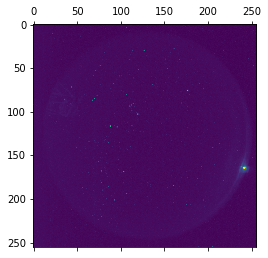

In [70]:
inputs, classes = next(iter(dataloaders['train']))
# plt.matshow(np.log(inputs[3,0,:,:]))
plt.matshow(inputs[3,0,:,:])
# print(inputs.shape)
# print(classes)

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=4):
        super(ResNet, self).__init__()
        self.inchannel = 64
        #change the channel to 30
        self.conv1 = nn.Sequential(
            nn.Conv2d(30, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(32768, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)
net = ResNet18()
use_gpu = torch.cuda.is_available()  # 
if use_gpu:
    net = net.cuda()
epc = 100
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.0001, betas=(0.9, 0.999))
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
trainloader = dataloaders['train']
valloader = dataloaders['val']
EPOCH = 135   #total epoches
pre_epoch = 0  # epoches existed
LR = 0.1        


In [76]:
epc = 4
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
accuracy_T = np.zeros(epc)
accuracy = np.zeros(epc)
j = 0
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
trainloader = dataloaders['train']
valloader = dataloaders['val']
testloader = dataloaders['test']
# EPOCH = 135   #total epoches
pre_epoch = 0  # epoches existed
LR = 0.1       
n_val_samples = 4870 * 0.2
for epoch in range(epc):  # loop over the dataset multiple times
    correct = 0.0
    total = 0.0
    running_loss = 0.0
    running_loss_V = 0.0
    correct_T = 0.0
    total_T = 0.0
    
    running_loss = 0.0
    print('Current epoch:',epoch)
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.cuda()
        labels = labels.type(torch.FloatTensor)
        labels = labels.cuda()
#         print(inputs.size())
#         inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
#         labels = labels.view(-1,4)

        labels = labels.long()
        
        correct_T += (predicted == labels.view(labels.size(1), -1)[0]).sum().item()
        
        total_T += labels.size(0)
        accuracy_T[epoch] = 100 * correct_T / total_T
        print('correct_t:',correct_T,total_T)
        print(predicted)
        print(labels)
        loss = criterion(outputs, labels.view(labels.size(1), -1)[0])
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 200== 199:    # print every 200 mini-batches
            print('[%d, %5d] training loss: %.3f training accuracy: %.2f' %
                  (epoch + 1, i + 1, running_loss /  200, accuracy_T[epoch]))
            for data in valloader:
                images, labels = data
                images = images.type(torch.FloatTensor)
                images = images.cuda()
                labels = labels.type(torch.FloatTensor)
                labels = labels.cuda()
                
              
                outputs = net(images)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                labels = labels.long()
                #print(total ,'   ', correct)
                correct += (predicted == labels.view(labels.size(1), -1)[0]).sum().item()
                accuracy[epoch] = 100 * correct / total
                loss = criterion(outputs, labels.view(labels.size(1), -1)[0])
                running_loss_V += loss.item()
            loss_mat[epoch] = running_loss / 200
            loss_V[epoch] = running_loss_V / (n_val_samples/4)
            print('Validation loss: %.3f validation accuracy: %.2f' %
                (loss_V[epoch] , accuracy[epoch]))
            running_loss = 0.0
            running_loss_V = 0.0
            correct = 0
            total = 0

print('Finished Training')

Current epoch: 0
correct_t: 4.0 4.0
tensor([3, 1, 0, 2], device='cuda:0')
tensor([[3],
        [1],
        [0],
        [2]], device='cuda:0')
correct_t: 7.0 8.0
tensor([0, 3, 3, 0], device='cuda:0')
tensor([[3],
        [3],
        [3],
        [0]], device='cuda:0')


KeyboardInterrupt: 

In [17]:
print(predicted)
print(labels)
print()
print(predicted == labels.view(labels.size(1), -1)[0])

tensor([2, 2, 2, 2], device='cuda:0')
tensor([[2],
        [0],
        [0],
        [1]], device='cuda:0')

tensor([1, 0, 0, 0], device='cuda:0', dtype=torch.uint8)


In [73]:
correct = 0
total = 0
crt = [0,0,0,0]
total_mat = [0,0,0,0]
with torch.no_grad():
    for data in dataloaders['test']:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
        images, labels = data
        images = images.type(torch.FloatTensor)
        images = images.cuda()
        labels = labels.type(torch.FloatTensor)
        labels = labels.cuda()
        outputs = net(images)
                
        _, predicted = torch.max(outputs.data, 1)
        print(labels, predicted,"labels and predicted")
        total += 1
        labels = labels.long()
        total_mat[labels] += 1
        if (predicted == labels.view(labels.size(1), -1)[0]).sum().item()==1:
            crt[labels]+=1
        
        correct += (predicted == labels.view(labels.size(1), -1)[0]).sum().item()
        print(total ,'   ', correct)
       

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

tensor([[2.]], device='cuda:0') tensor([3], device='cuda:0') labels and predicted
1     0
tensor([[3.]], device='cuda:0') tensor([2], device='cuda:0') labels and predicted
2     0
tensor([[0.]], device='cuda:0') tensor([0], device='cuda:0') labels and predicted
3     1
tensor([[0.]], device='cuda:0') tensor([0], device='cuda:0') labels and predicted
4     2
tensor([[3.]], device='cuda:0') tensor([1], device='cuda:0') labels and predicted
5     2
tensor([[3.]], device='cuda:0') tensor([3], device='cuda:0') labels and predicted
6     3
tensor([[3.]], device='cuda:0') tensor([0], device='cuda:0') labels and predicted
7     3
tensor([[3.]], device='cuda:0') tensor([3], device='cuda:0') labels and predicted
8     4
tensor([[3.]], device='cuda:0') tensor([3], device='cuda:0') labels and predicted
9     5


KeyboardInterrupt: 

In [51]:
print(crt)
print(total_mat)
print(np.asarray(crt)/np.asarray(total_mat))

[5, 0, 1, 514]
[74, 36, 59, 593]
[0.06756757 0.         0.01694915 0.86677909]


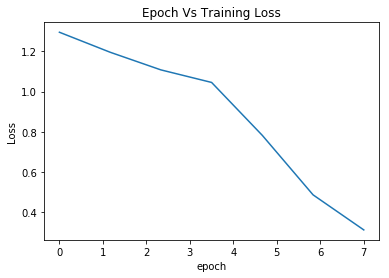

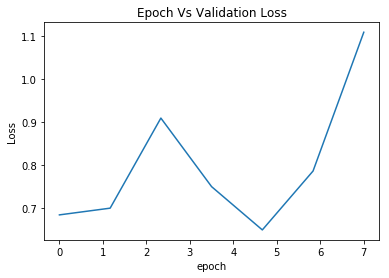

In [74]:

epc = np.linspace(0,epoch,epoch)
plt.plot(epc, loss_mat[0:epoch])
plt.title("Epoch Vs Training Loss")
plt.xlabel("epoch") #
plt.ylabel("Loss") #

plt.show()

plt.plot(epc, loss_V[0:epoch])
plt.title("Epoch Vs Validation Loss")
plt.xlabel("epoch") #
plt.ylabel("Loss") #

plt.show()

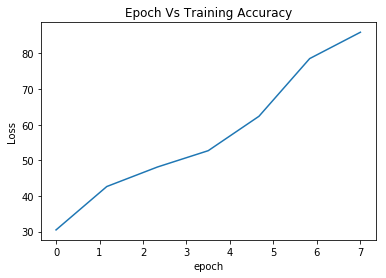

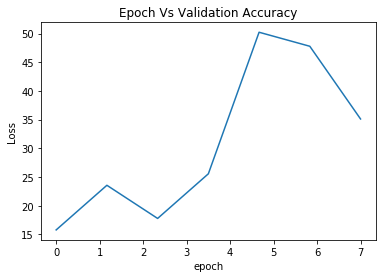

In [75]:

epc = np.linspace(0,epoch,epoch)
plt.plot(epc, accuracy_T[0:epoch])
plt.title("Epoch Vs Training Accuracy")
plt.xlabel("epoch") #
plt.ylabel("Loss") #

plt.show()

plt.plot(epc, accuracy[0:epoch])
plt.title("Epoch Vs Validation Accuracy")
plt.xlabel("epoch") #
plt.ylabel("Loss") #

plt.show()

### Testing

In [35]:
print(loss_mat[:epoch])
print(loss_V[:epoch])

[1.09411376 1.08886511 1.0462627  0.98059638 0.68227106 0.49907035
 0.33403772 0.26549406 0.21624511 0.16484554 0.08384116 0.09853118
 0.07038137 0.12713481 0.04569868 0.03079484]
[0.71089773 1.09136727 0.91295599 1.0220887  0.30848949 0.29591233
 0.16888583 0.39076482 0.10478241 0.03285191 0.07364065 0.16654263
 0.01859543 0.08875581 0.0066546  0.00863669]


In [23]:
print(correct)
print(total_T)
print(running_loss)
print(labels.view(labels.size(1), -1)[0])
print(predicted)
loss = criterion(outputs, labels.view(labels.size(1), -1)[0])
print(criterion(outputs, labels.view(labels.size(1), -1)[0]))

0.0
20.0
5.871628165245056
tensor([1, 1, 3, 3], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
tensor(1.8919, device='cuda:0', grad_fn=<NllLossBackward>)


# Save and load the network

In [31]:
# torch.save(net.state_dict(),'E:\\Starring-at-the-Night-Sky\\16epc.pkl')

In [20]:
torch.save(net ,'E:\\Starring-at-the-Night-Sky\\11epc.pkl')

C:\Users\u5889098\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\u5889098\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
torch.load('E:\\Starring-at-the-Night-Sky\\16epc.pkl')

# Test

In [18]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(30, 32, 5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(262144, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.conv1(x))
        x = self.conv1_bn(x)
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_bn(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

net = Net()

use_gpu = torch.cuda.is_available()  # 
if use_gpu:
    print('Use CUDA')
    net = net.cuda()
#    
import torch.optim as optim


#criterion =nn.BCELoss()

#criterion =nn.NLLLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean')

#m= nn.Sigmoid()
#criterion = nn.NLLLoss()
#criterion=nn.BCECriterion()


criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.001, betas=(0.9, 0.999))
epc = 30
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
accuracy_T = np.zeros(epc)
accuracy = np.zeros(epc)
j = 0
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
trainloader = dataloaders['train']
testloader = dataloaders['val']
EPOCH = 135   #total epoches
pre_epoch = 0  # epoches existed
LR = 0.1       

Use CUDA


KeyboardInterrupt: 

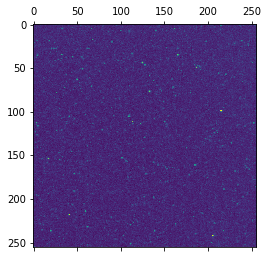

In [23]:
epc = 100
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
accuracy_T = np.zeros(epc)
accuracy = np.zeros(epc)
j = 0
loss_mat = np.zeros(epc)
loss_V = np.zeros(epc)
trainloader = dataloaders['train']
testloader = dataloaders['val']
EPOCH = 135   #total epoches
pre_epoch = 0  # epoches existed
LR = 0.1       
for epoch in range(epc):  # loop over the dataset multiple times
    correct = 0.0
    total = 0.0
    running_loss = 0.0
    running_loss_V = 0.0
    correct_T = 0.0
    total_T = 0.0
    j = 0
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs
        inputs, labels = data
        if j==0:
            plt.matshow(np.log(inputs[0,0,:,:]))
        j+=1

print('Finished Training')

In [77]:
from torchviz import make_dot

ModuleNotFoundError: No module named 'torchviz'